In [1]:
import sys
if 'google.colab' in sys.modules:  
    # Installing requisite packages
    !pip install datasets transformers==4.37.2 evaluate accelerate optimum auto-gptq

    from google.colab import drive
    drive.mount('/content/drive')

file_path = '/content/drive/My Drive/VSM_BRIMS_03_02.csv'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 6.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 98.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 453.7/453.7 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.5/23.5 MB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 89.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB

In [2]:
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer

In [3]:
df = pd.read_csv('/content/drive/My Drive/VSM_BRIMS_03_02.csv', header=0)

df.columns = ['task', 'participant', 'trial', 'decision_type', 'choice', 'OEE1', 'OEE2', 'CT1', 'CT2']

print(df.head())
df['multiclass_target'] = df['choice'] * 3 + df['decision_type']
print(df.head())

   task  participant  trial  decision_type  choice  OEE1  OEE2  CT1  CT2
0     0            0      0              0       1    88    86   46   48
1     0            0      1              1       1    88    86   46   48
2     0            0      2              0       1    88    86   46   48
3     0            0      3              0       1    88    86   46   48
4     0            0      4              0       1    88    86   46   48
   task  participant  trial  decision_type  choice  OEE1  OEE2  CT1  CT2  \
0     0            0      0              0       1    88    86   46   48   
1     0            0      1              1       1    88    86   46   48   
2     0            0      2              0       1    88    86   46   48   
3     0            0      3              0       1    88    86   46   48   
4     0            0      4              0       1    88    86   46   48   

   multiclass_target  
0                  3  
1                  4  
2                  3  
3            

In [4]:
if 'task' in df.columns:
    print("Task column is present.")
else:
    print("Task column is missing. Available columns:", df.columns)

Task column is present.


In [5]:
# iterative prompts
import pandas as pd

# question template
question_template = (
    "Our manufacturing line has two sections with potential defect sources: pre-assembly (0) and assembly (1). "
    "Pre-assembly takes {CT1} seconds with an Overall Equipment Effectiveness(OEE) rate of {OEE1}%, while assembly takes {CT2} seconds with an OEE rate of {OEE2}%. "
    "To reduce total assembly time by 4 seconds, we need to identify which section can be shortened with minimal defect increase. "
    "It's important to note that reducing cycle time will also lead to an increase in headcount costs."
    "There are two options: reduce pre-assembly time (0) or reduce assembly time (1).\nQ: Which section do you choose to optimize? A: "
)
text = []

# Iterate over each task
for task in df['task'].unique():
    df_task = df[df['task'] == task]
    print(task)
    if not df_task.empty:
        OEE1 = df_task['OEE1'].iloc[0]
        OEE2 = df_task['OEE2'].iloc[0]
        CT1 = df_task['CT1'].iloc[0]
        CT2 = df_task['CT2'].iloc[0]
        prompt = question_template.format(OEE1=OEE1, OEE2=OEE2, CT1=CT1, CT2=CT2)

        # Apply the prompt to each row in the task
        for index, row in df_task.iterrows():
            text.append(prompt)
    else:
        
        num_trials_expected = 15 
        text.extend(["Data not available for this task."] * num_trials_expected)


if len(text) < len(df):
    text.extend(["Data missing due to processing error."] * (len(df) - len(text)))
elif len(text) > len(df):
    text = text[:len(df)]


df['text'] = text


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


In [6]:
dat = Dataset.from_pandas(df)
dat

Dataset({
    features: ['task', 'participant', 'trial', 'decision_type', 'choice', 'OEE1', 'OEE2', 'CT1', 'CT2', 'multiclass_target', 'text'],
    num_rows: 2012
})

In [7]:
dat[0]

{'task': 0,
 'participant': 0,
 'trial': 0,
 'decision_type': 0,
 'choice': 1,
 'OEE1': 88,
 'OEE2': 86,
 'CT1': 46,
 'CT2': 48,
 'multiclass_target': 3,
 'text': "Our manufacturing line has two sections with potential defect sources: pre-assembly (0) and assembly (1). Pre-assembly takes 46 seconds with an Overall Equipment Effectiveness(OEE) rate of 88%, while assembly takes 48 seconds with an OEE rate of 86%. To reduce total assembly time by 4 seconds, we need to identify which section can be shortened with minimal defect increase. It's important to note that reducing cycle time will also lead to an increase in headcount costs.There are two options: reduce pre-assembly time (0) or reduce assembly time (1).\nQ: Which section do you choose to optimize? A: "}

In [8]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

# Load model
model_ckpt = 'TheBloke/LLama-2-7B-GPTQ'
model = AutoModelForCausalLM.from_pretrained(
    model_ckpt,
    device_map="auto",
    revision="main"
)
tokenizer = AutoTokenizer.from_pretrained(model_ckpt, use_fast=True)

print (model.config.to_json_string())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/784 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.90G [00:00<?, ?B/s]

Some weights of the model checkpoint at TheBloke/LLama-2-7B-GPTQ were not used when initializing LlamaForCausalLM: ['model.layers.0.mlp.down_proj.bias', 'model.layers.0.mlp.gate_proj.bias', 'model.layers.0.mlp.up_proj.bias', 'model.layers.0.self_attn.k_proj.bias', 'model.layers.0.self_attn.o_proj.bias', 'model.layers.0.self_attn.q_proj.bias', 'model.layers.0.self_attn.v_proj.bias', 'model.layers.1.mlp.down_proj.bias', 'model.layers.1.mlp.gate_proj.bias', 'model.layers.1.mlp.up_proj.bias', 'model.layers.1.self_attn.k_proj.bias', 'model.layers.1.self_attn.o_proj.bias', 'model.layers.1.self_attn.q_proj.bias', 'model.layers.1.self_attn.v_proj.bias', 'model.layers.10.mlp.down_proj.bias', 'model.layers.10.mlp.gate_proj.bias', 'model.layers.10.mlp.up_proj.bias', 'model.layers.10.self_attn.k_proj.bias', 'model.layers.10.self_attn.o_proj.bias', 'model.layers.10.self_attn.q_proj.bias', 'model.layers.10.self_attn.v_proj.bias', 'model.layers.11.mlp.down_proj.bias', 'model.layers.11.mlp.gate_proj.b

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/411 [00:00<?, ?B/s]

{
  "_name_or_path": "TheBloke/LLama-2-7B-GPTQ",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "max_length": 4096,
  "max_position_embeddings": 4096,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 32,
  "pad_token_id": 0,
  "pretraining_tp": 1,
  "quantization_config": {
    "batch_size": 1,
    "bits": 4,
    "block_name_to_quantize": null,
    "cache_block_outputs": true,
    "damp_percent": 0.01,
    "dataset": null,
    "desc_act": false,
    "exllama_config": {
      "version": 1
    },
    "group_size": 128,
    "max_input_length": null,
    "model_seqlen": null,
    "module_name_preceding_first_block": null,
    "modules_in_block_to_quantize": null,
    "pad_token_id": null,
    "quant_method": "gptq",
    "sym": tru

In [9]:
!pip install peft

In [10]:
tokenizer.pad_token = tokenizer.eos_token
batch_tokenizer = lambda batch: tokenizer(batch['text'], padding=True, truncation=True)

#  Tokenizing the dataset
dat = dat.map(batch_tokenizer, batched=True)
dat[0]

Map:   0%|          | 0/2012 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


{'task': 0,
 'participant': 0,
 'trial': 0,
 'decision_type': 0,
 'choice': 1,
 'OEE1': 88,
 'OEE2': 86,
 'CT1': 46,
 'CT2': 48,
 'multiclass_target': 3,
 'text': "Our manufacturing line has two sections with potential defect sources: pre-assembly (0) and assembly (1). Pre-assembly takes 46 seconds with an Overall Equipment Effectiveness(OEE) rate of 88%, while assembly takes 48 seconds with an OEE rate of 86%. To reduce total assembly time by 4 seconds, we need to identify which section can be shortened with minimal defect increase. It's important to note that reducing cycle time will also lead to an increase in headcount costs.There are two options: reduce pre-assembly time (0) or reduce assembly time (1).\nQ: Which section do you choose to optimize? A: ",
 'input_ids': [1,
  8680,
  12012,
  3864,
  1196,
  756,
  1023,
  13926,
  411,
  7037,
  23503,
  8974,
  29901,
  758,
  29899,
  26936,
  313,
  29900,
  29897,
  322,
  11470,
  313,
  29896,
  467,
  4721,
  29899,
  26936,


In [11]:
dat[0]

{'task': 0,
 'participant': 0,
 'trial': 0,
 'decision_type': 0,
 'choice': 1,
 'OEE1': 88,
 'OEE2': 86,
 'CT1': 46,
 'CT2': 48,
 'multiclass_target': 3,
 'text': "Our manufacturing line has two sections with potential defect sources: pre-assembly (0) and assembly (1). Pre-assembly takes 46 seconds with an Overall Equipment Effectiveness(OEE) rate of 88%, while assembly takes 48 seconds with an OEE rate of 86%. To reduce total assembly time by 4 seconds, we need to identify which section can be shortened with minimal defect increase. It's important to note that reducing cycle time will also lead to an increase in headcount costs.There are two options: reduce pre-assembly time (0) or reduce assembly time (1).\nQ: Which section do you choose to optimize? A: ",
 'input_ids': [1,
  8680,
  12012,
  3864,
  1196,
  756,
  1023,
  13926,
  411,
  7037,
  23503,
  8974,
  29901,
  758,
  29899,
  26936,
  313,
  29900,
  29897,
  322,
  11470,
  313,
  29896,
  467,
  4721,
  29899,
  26936,


In [12]:
dat.set_format('torch', columns=['input_ids', 'attention_mask'])
dat

Dataset({
    features: ['task', 'participant', 'trial', 'decision_type', 'choice', 'OEE1', 'OEE2', 'CT1', 'CT2', 'multiclass_target', 'text', 'input_ids', 'attention_mask'],
    num_rows: 2012
})

In [13]:
import torch
torch.manual_seed(42) # For reproducibility
from transformers import AutoModel

In [14]:
# Loading the model and moving it to the GPU if available
if torch.cuda.is_available():  
    device = torch.device('cuda')
elif torch.backends.mps.is_available(): 
    device = torch.device('mps')
else:
    device = torch.device('cpu')

device

device(type='cuda')

# Fine tuning for predicting decision making behavior

In [15]:
num_rows = len(dat['choice'])
print("Number of rows in 'choice' column:", num_rows)

Number of rows in 'choice' column: 2012


In [16]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate

In [17]:
# Splitting the data into train and test sets
dat = dat.train_test_split(test_size=.2, seed=42)
dat

DatasetDict({
    train: Dataset({
        features: ['task', 'participant', 'trial', 'decision_type', 'choice', 'OEE1', 'OEE2', 'CT1', 'CT2', 'multiclass_target', 'text', 'input_ids', 'attention_mask'],
        num_rows: 1609
    })
    test: Dataset({
        features: ['task', 'participant', 'trial', 'decision_type', 'choice', 'OEE1', 'OEE2', 'CT1', 'CT2', 'multiclass_target', 'text', 'input_ids', 'attention_mask'],
        num_rows: 403
    })
})

In [18]:
type(dat['train'])

datasets.arrow_dataset.Dataset

In [19]:
from transformers import AutoModelForCausalLM, AutoTokenizer

peft_model_id = "ybelkada/opt-350m-lora"

model.load_adapter(peft_model_id)

adapter_config.json:   0%|          | 0.00/416 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/6.30M [00:00<?, ?B/s]

Loading adapter weights from ybelkada/opt-350m-lora led to unexpected keys not found in the model:  ['model.decoder.layers.0.self_attn.q_proj.lora_A.default.weight', 'model.decoder.layers.0.self_attn.q_proj.lora_B.default.weight', 'model.decoder.layers.0.self_attn.v_proj.lora_A.default.weight', 'model.decoder.layers.0.self_attn.v_proj.lora_B.default.weight', 'model.decoder.layers.1.self_attn.q_proj.lora_A.default.weight', 'model.decoder.layers.1.self_attn.q_proj.lora_B.default.weight', 'model.decoder.layers.1.self_attn.v_proj.lora_A.default.weight', 'model.decoder.layers.1.self_attn.v_proj.lora_B.default.weight', 'model.decoder.layers.10.self_attn.q_proj.lora_A.default.weight', 'model.decoder.layers.10.self_attn.q_proj.lora_B.default.weight', 'model.decoder.layers.10.self_attn.v_proj.lora_A.default.weight', 'model.decoder.layers.10.self_attn.v_proj.lora_B.default.weight', 'model.decoder.layers.11.self_attn.q_proj.lora_A.default.weight', 'model.decoder.layers.11.self_attn.q_proj.lora_B.

In [20]:
from datasets import load_dataset, DatasetDict

train_dataset = dat['train']
test_dataset = dat['test']


def format_dataset(example):
    example['labels'] = example['choice']
    return example

train_dataset = train_dataset.map(format_dataset, batched=False)
test_dataset = test_dataset.map(format_dataset, batched=False)

Map:   0%|          | 0/1609 [00:00<?, ? examples/s]

Map:   0%|          | 0/403 [00:00<?, ? examples/s]

In [21]:
#import cognitive vector
file_path = '/content/drive/My Drive/mean_output8.csv'
cog_data = pd.read_csv(file_path)
cognitive_vector_data = cog_data.iloc[-1].values
print (cognitive_vector_data)
# Convert the numpy array to a PyTorch tensor
cognitive_vector = torch.tensor(cognitive_vector_data, dtype=torch.float)

cognitive_vector = torch.nn.Parameter(cognitive_vector)


[ 0.33658036 -0.821017   -0.43053366 ... -0.36542332  0.2037078
 -0.14681532]


In [ ]:
#import cognitivelayerwrapper and CognitiveLLaMA
import torch
from cognitiveModels import CognitiveLayerWrapper, CognitiveLLaMA

model = CognitiveLLaMA(model, cognitive_vector, target_layer_num=8, multiplier=5, dropout_prob=0.5)

In [25]:
class CustomTrainer(Trainer):
    def get_train_dataloader(self):
        dataloader = super().get_train_dataloader()
        #print("Sample batch from dataloader:", next(iter(dataloader)))
        return dataloader

    def compute_loss(self, model, inputs, return_outputs=False):
        #print("Received inputs in compute_loss:", inputs)
        if 'labels' not in inputs:
            raise ValueError("Labels key missing in inputs during training.")
        labels = inputs.pop('labels').long()
        outputs = model(**inputs)
        logits = outputs[0] if isinstance(outputs, tuple) else outputs
        loss_fct = torch.nn.CrossEntropyLoss()
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss



In [26]:
import torch
import torch.nn.functional as F

def compute_metrics(pred):
    labels = pred.label_ids
    if isinstance(pred.predictions, tuple):
        logits = pred.predictions[0]
    else:
        logits = pred.predictions

    preds = logits.argmax(-1)

    # Calculate probabilities and NLL loss using PyTorch
    probabilities = F.softmax(torch.tensor(logits), dim=-1)
    labels_tensor = torch.tensor(labels, dtype=torch.long)
    nll_loss = F.nll_loss(probabilities.log(), labels_tensor).item()


    return {
        'nll_loss': nll_loss
    }


In [27]:
import gc
gc.collect()

156

In [ ]:
#huggingface trainer, to train the model
from transformers import Trainer, TrainingArguments

model.to(device)
model_name = f"{model_ckpt}-finetuned"
batch_size = 2
training_args = TrainingArguments(
    output_dir= model_name,
    save_safetensors = False,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy='epoch',
    logging_strategy='epoch',
    learning_rate=1e-5,
    num_train_epochs=10,
    weight_decay=0.01,
    gradient_accumulation_steps=2,
    max_grad_norm=1.0,
    optim='adamw_torch'
)

trainer = CustomTrainer(
    model= model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics

)

trainer.train()

In [35]:
# Access the training history
metrics_history = trainer.state.log_history

# Extract the NLL loss from evaluation phases
nll_values = [entry['eval_nll_loss'] for entry in metrics_history if 'eval_nll_loss' in entry]
print(nll_values)


[0.6439151167869568, 0.6434608697891235, 0.6522118449211121, 0.6466344594955444, 0.6519626975059509, 0.6487606763839722, 0.6464627385139465, 0.6476824879646301, 0.646708071231842, 0.6475809812545776]


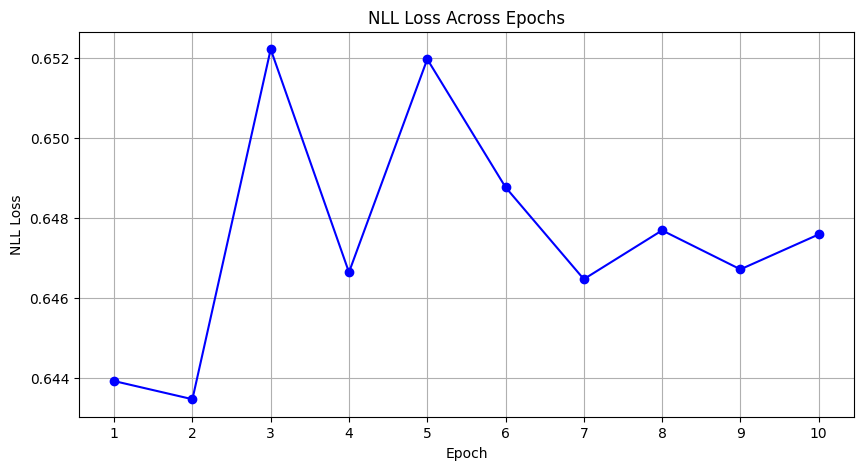

In [37]:
import matplotlib.pyplot as plt

# Assuming `nll_values` holds your NLL loss data from the metrics
epochs = range(1, len(nll_values) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, nll_values, marker='o', linestyle='-', color='blue')
plt.title('NLL Loss Across Epochs')
plt.xlabel('Epoch')
plt.ylabel('NLL Loss')
plt.grid(True)
plt.xticks(epochs)  # Ensure all epoch numbers are marked
plt.show()


In [29]:
print (model.__dict__)

{'training': False, '_parameters': OrderedDict(), '_buffers': OrderedDict(), '_non_persistent_buffers_set': set(), '_backward_pre_hooks': OrderedDict(), '_backward_hooks': OrderedDict(), '_is_full_backward_hook': None, '_forward_hooks': OrderedDict(), '_forward_hooks_with_kwargs': OrderedDict(), '_forward_hooks_always_called': OrderedDict(), '_forward_pre_hooks': OrderedDict(), '_forward_pre_hooks_with_kwargs': OrderedDict(), '_state_dict_hooks': OrderedDict(), '_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_pre_hooks': OrderedDict(), '_load_state_dict_post_hooks': OrderedDict(), '_modules': OrderedDict([('dropout', Dropout(p=0.5, inplace=False)), ('cognitive_layer', CognitiveLayerWrapper(
  (base_model): LlamaForCausalLM(
    (model): LlamaModel(
      (embed_tokens): Embedding(32000, 4096, padding_idx=0)
      (layers): ModuleList(
        (0-31): 32 x LlamaDecoderLayer(
          (self_attn): LlamaSdpaAttention(
            (rotary_emb): LlamaRotaryEmbedding()
            